In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import torch
print(torch.cuda.is_available()) # True
print(torch.cuda.device_count()) # 1
print(torch.cuda.current_device()) # 0
print(torch.cuda.device(0)) # <torch.cuda.device at 0x7efce0b03be0>
print(torch.cuda.get_device_name(0)) # 'GeForce GTX 950M'

True
1
0
NVIDIA TITAN Xp


In [4]:
import sys
sys.path.append("../../..")

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from librep.datasets.har.loaders import (
    KuHar_BalancedView20HzMotionSenseEquivalent
)

2022-11-24 14:11:20.530783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 14:11:22.061762: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-24 14:11:22.061894: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-24 14:11:22.061910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [7]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [8]:
# KuHar Loader
loader = KuHar_BalancedView20HzMotionSenseEquivalent(
    root_dir="../../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1", 
    download=False
)

# Print the readme (optional)
# loader.print_readme()

In [9]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=3114, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=246, features=360, no. window=6, label_columns='standard activity code')

In [10]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

In [11]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(3114, 360) (3114,) (246, 360) (246,)


# Aplicar FFT

In [12]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [13]:
train_dataset_fft = transformer(train_val)
test_dataset_fft = transformer(test)

In [14]:
print(train_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3114, 180)
(246, 180)


In [15]:
print(np.max(train_dataset_fft.X))

1199.4899017510002


In [16]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

In [17]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(3114, 180) (3114,) (246, 180) (246,)


# Visualization helper

In [18]:
# 0: sit (569 train, 101 validation, 170 test)
# 1: stand (569 train, 101 validation, 170 test)
# 2: walk (569 train, 101 validation, 170 test)
# 3: stair up (569 train, 101 validation, 170 test)
# 4: stair down (569 train, 101 validation, 170 test)
# 5: run (569 train, 101 validation, 170 test)
def visualize(X, Y):
    labels = ['sit', 'stand', 'walk', 'stair up', 'stair down', 'run']
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=labels[name])
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [19]:
# Variables to reuse
model_dim = 10
model_epc = 1500

# Reducing with Convolutional Topological Autoencoders (L=0)

In [20]:
# model_lam = 1
# model_dim = 10
# model_epc = 1500
# topo_reducer = TopologicalDimensionalityReduction(
#     ae_model='ConvolutionalAutoencoder_custom_dim2',
#     lam = model_lam,
#     ae_kwargs = {'input_dims':(1, 180), 'custom_dim':model_dim},
#     input_shape = (-1, 1, 1, 180),
#     patience = None,
#     num_epochs = model_epc
# )

In [21]:
model_lam = 0
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim3',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:451.0011, Loss-ae:451.0011, Loss-topo:121.5273
Epoch:2, P:None, Loss:402.6572, Loss-ae:402.6572, Loss-topo:195.4783
Epoch:3, P:None, Loss:355.3270, Loss-ae:355.3270, Loss-topo:371.9784
Epoch:4, P:None, Loss:285.8903, Loss-ae:285.8903, Loss-topo:1333.7914
Epoch:5, P:None, Loss:248.2984, Loss-ae:248.2984, Loss-topo:2127.6997
Epoch:6, P:None, Loss:210.7506, Loss-ae:210.7506, Loss-topo:3129.6794
Epoch:7, P:None, Loss:187.0626, Loss-ae:187.0626, Loss-topo:5375.4464
Epoch:8, P:None, Loss:165.8289, Loss-ae:165.8289, Loss-topo:7591.4577
Epoch:9, P:None, Loss:149.9953, Loss-ae:149.9953, Loss-topo:9330.5111
Epoch:10, P:None, Loss:141.9063, Loss-ae:141.9063, Loss-topo:9804.6144
Epoch:11, P:None, Loss:135.3181, Loss-ae:135.3181, Loss-topo:11350.7084
Epoch:12, P:None, Loss:130.3288, Loss-ae:130.3288, Loss-topo:12702.5871
Epoch:13, P:None, Loss:124.6572, Loss-ae:124.6572, Loss-topo:13475.1596
Epoch:14, P:None, Loss:119.3865, Loss-ae:119.3865, Loss-topo:14824.5051
Epoch:15, P:No

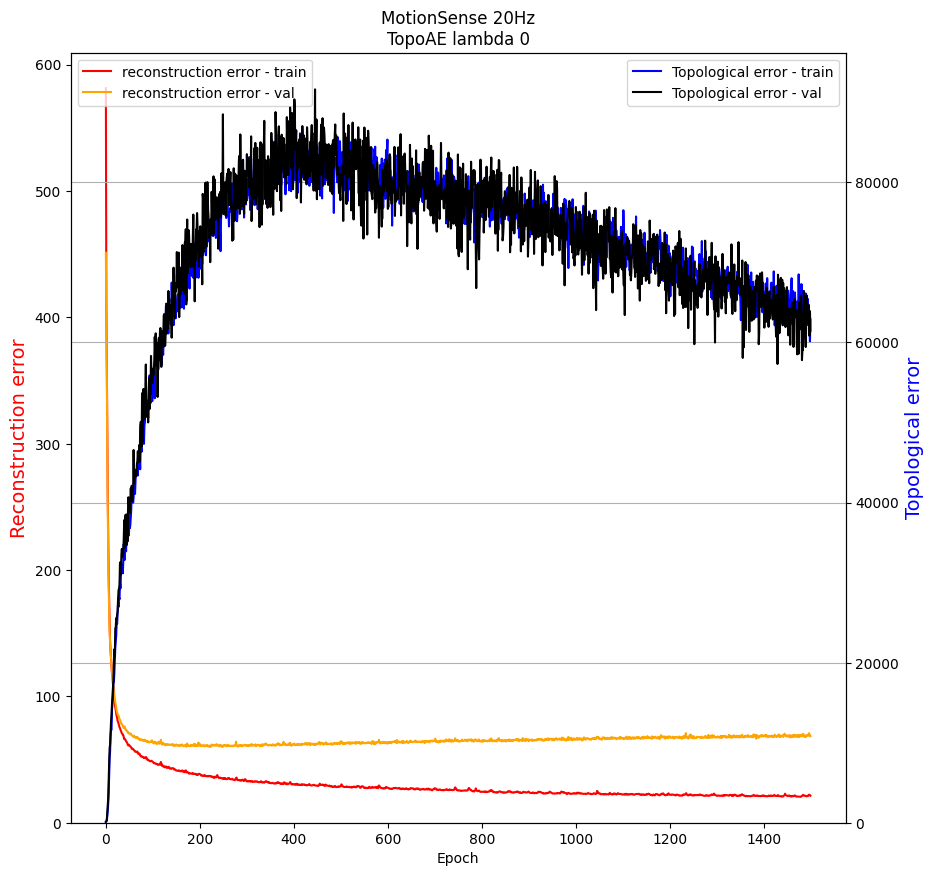

In [22]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [23]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [24]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [25]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7126016260162602,
 'RF-F1': 0.7134656386812372,
 'SVC-ACC': 0.6951219512195121,
 'SVC-F1': 0.7485087506059533,
 'KNN-ACC': 0.7032520325203252,
 'KNN-F1': 0.7036261401360739}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


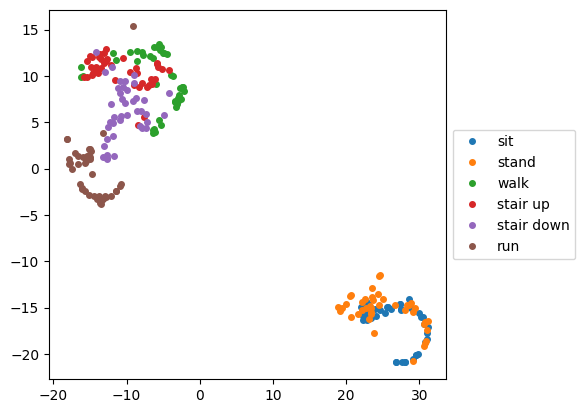

In [26]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=1)

In [27]:
model_lam = 1
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim3',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:476.7799, Loss-ae:450.3736, Loss-topo:26.4063
Epoch:2, P:None, Loss:419.5749, Loss-ae:408.6623, Loss-topo:10.9127
Epoch:3, P:None, Loss:387.4268, Loss-ae:375.7527, Loss-topo:11.6741
Epoch:4, P:None, Loss:372.7481, Loss-ae:361.6513, Loss-topo:11.0968
Epoch:5, P:None, Loss:362.3492, Loss-ae:352.0079, Loss-topo:10.3413
Epoch:6, P:None, Loss:350.4502, Loss-ae:340.8463, Loss-topo:9.6039
Epoch:7, P:None, Loss:334.5452, Loss-ae:324.7841, Loss-topo:9.7611
Epoch:8, P:None, Loss:304.7228, Loss-ae:289.3924, Loss-topo:15.3305
Epoch:9, P:None, Loss:281.6622, Loss-ae:265.7800, Loss-topo:15.8821
Epoch:10, P:None, Loss:266.9143, Loss-ae:252.2030, Loss-topo:14.7113
Epoch:11, P:None, Loss:255.1810, Loss-ae:244.9037, Loss-topo:10.2773
Epoch:12, P:None, Loss:245.2890, Loss-ae:235.1191, Loss-topo:10.1699
Epoch:13, P:None, Loss:239.6640, Loss-ae:229.9509, Loss-topo:9.7131
Epoch:14, P:None, Loss:228.4955, Loss-ae:220.2499, Loss-topo:8.2456
Epoch:15, P:None, Loss:222.1263, Loss-ae:212.79

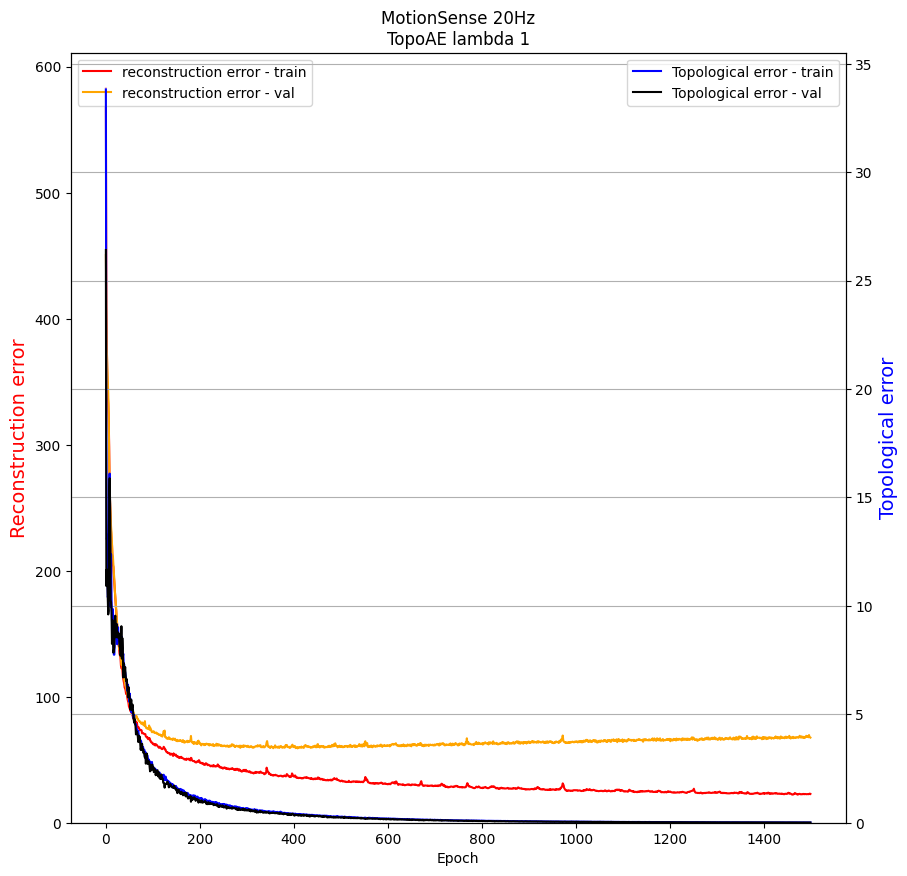

In [28]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [29]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [30]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [31]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7845528455284553,
 'RF-F1': 0.7824525231229449,
 'SVC-ACC': 0.6910569105691057,
 'SVC-F1': 0.7443341750995177,
 'KNN-ACC': 0.7439024390243902,
 'KNN-F1': 0.7430385118018001}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


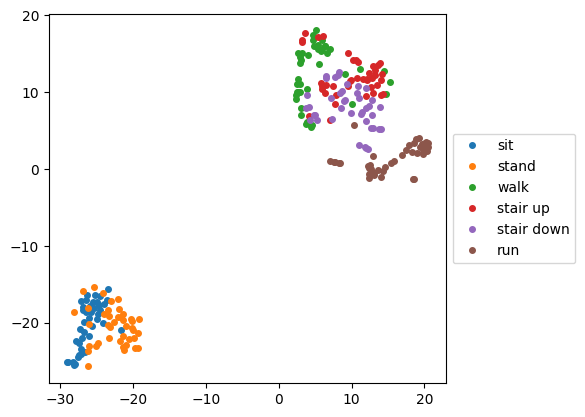

In [32]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=5)

In [33]:
model_lam = 5
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim3',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:803.0006, Loss-ae:801.9620, Loss-topo:0.2077
Epoch:2, P:None, Loss:500.7254, Loss-ae:465.1950, Loss-topo:7.1061
Epoch:3, P:None, Loss:419.6950, Loss-ae:404.3241, Loss-topo:3.0742
Epoch:4, P:None, Loss:385.0628, Loss-ae:370.6083, Loss-topo:2.8909
Epoch:5, P:None, Loss:374.3228, Loss-ae:360.2274, Loss-topo:2.8191
Epoch:6, P:None, Loss:365.9162, Loss-ae:356.9800, Loss-topo:1.7872
Epoch:7, P:None, Loss:357.0059, Loss-ae:349.4711, Loss-topo:1.5070
Epoch:8, P:None, Loss:350.4064, Loss-ae:341.8823, Loss-topo:1.7048
Epoch:9, P:None, Loss:350.0813, Loss-ae:342.8595, Loss-topo:1.4444
Epoch:10, P:None, Loss:339.6239, Loss-ae:332.9430, Loss-topo:1.3362
Epoch:11, P:None, Loss:318.8353, Loss-ae:305.6683, Loss-topo:2.6334
Epoch:12, P:None, Loss:290.2499, Loss-ae:273.4130, Loss-topo:3.3674
Epoch:13, P:None, Loss:275.2913, Loss-ae:263.2024, Loss-topo:2.4178
Epoch:14, P:None, Loss:264.9558, Loss-ae:253.6410, Loss-topo:2.2630
Epoch:15, P:None, Loss:254.9685, Loss-ae:245.7254, Loss-t

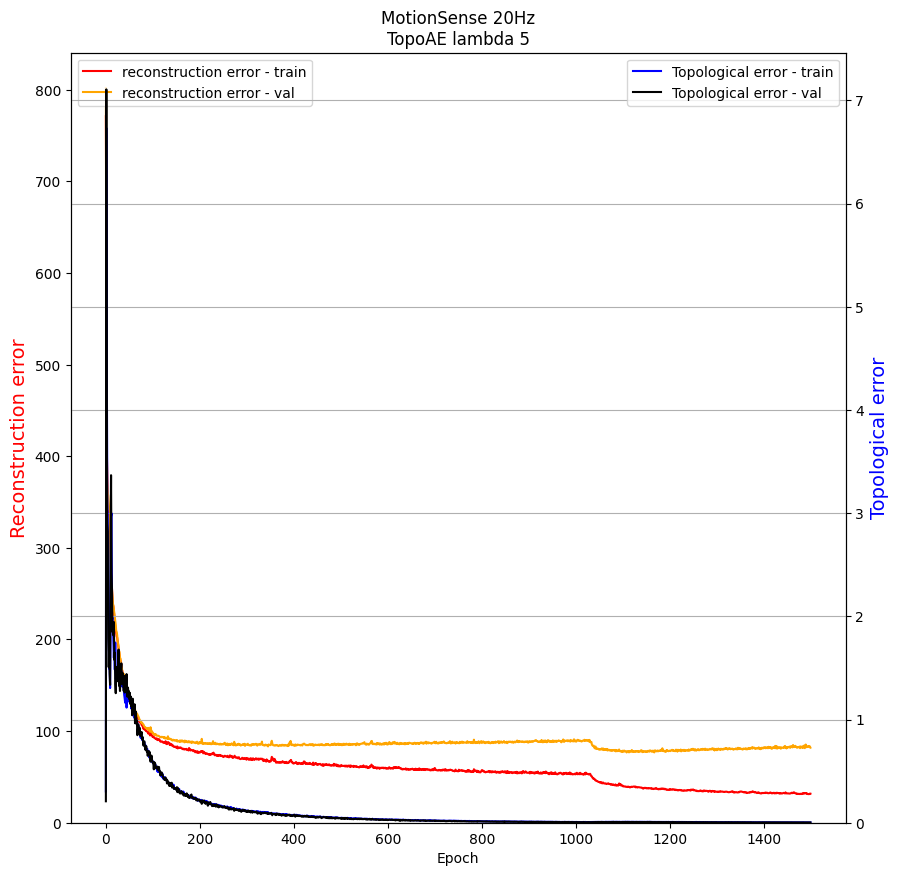

In [34]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [35]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [36]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [37]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.75,
 'RF-F1': 0.7498212412545733,
 'SVC-ACC': 0.6707317073170732,
 'SVC-F1': 0.7140057401062554,
 'KNN-ACC': 0.6504065040650406,
 'KNN-F1': 0.6460272388473318}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


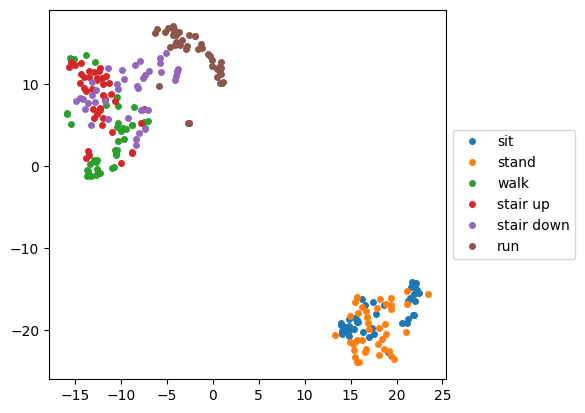

In [38]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=10)

In [39]:
model_lam = 10
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim3',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:790.9413, Loss-ae:788.8763, Loss-topo:0.2065
Epoch:2, P:None, Loss:518.3437, Loss-ae:493.5280, Loss-topo:2.4816
Epoch:3, P:None, Loss:439.1610, Loss-ae:424.0412, Loss-topo:1.5120
Epoch:4, P:None, Loss:400.4056, Loss-ae:385.1132, Loss-topo:1.5292
Epoch:5, P:None, Loss:384.4267, Loss-ae:369.5285, Loss-topo:1.4898
Epoch:6, P:None, Loss:364.7817, Loss-ae:356.1799, Loss-topo:0.8602
Epoch:7, P:None, Loss:358.5823, Loss-ae:350.1310, Loss-topo:0.8451
Epoch:8, P:None, Loss:354.6781, Loss-ae:347.0253, Loss-topo:0.7653
Epoch:9, P:None, Loss:351.6443, Loss-ae:345.0258, Loss-topo:0.6618
Epoch:10, P:None, Loss:346.7634, Loss-ae:341.5951, Loss-topo:0.5168
Epoch:11, P:None, Loss:340.6818, Loss-ae:332.9381, Loss-topo:0.7744
Epoch:12, P:None, Loss:327.6048, Loss-ae:319.6756, Loss-topo:0.7929
Epoch:13, P:None, Loss:309.6737, Loss-ae:294.2149, Loss-topo:1.5459
Epoch:14, P:None, Loss:288.8758, Loss-ae:274.5755, Loss-topo:1.4300
Epoch:15, P:None, Loss:271.5055, Loss-ae:258.8366, Loss-t

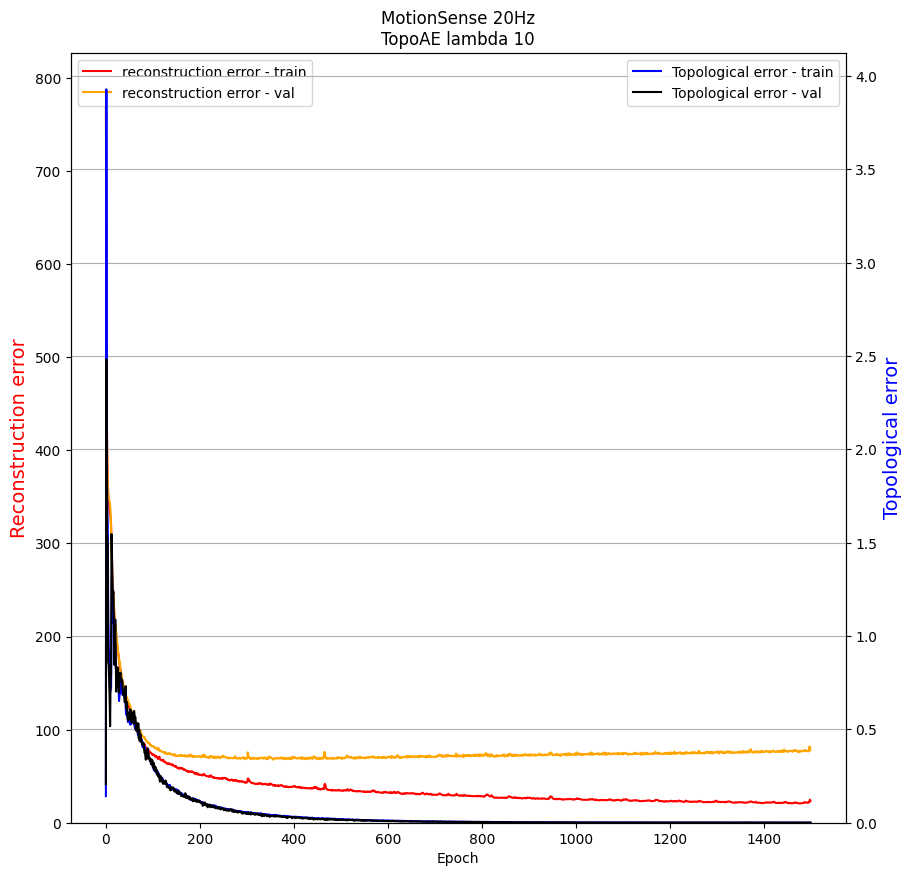

In [40]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [41]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [42]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [43]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7296747967479675,
 'RF-F1': 0.73044881727201,
 'SVC-ACC': 0.7032520325203252,
 'SVC-F1': 0.7009733151262235,
 'KNN-ACC': 0.7032520325203252,
 'KNN-F1': 0.700628817378173}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


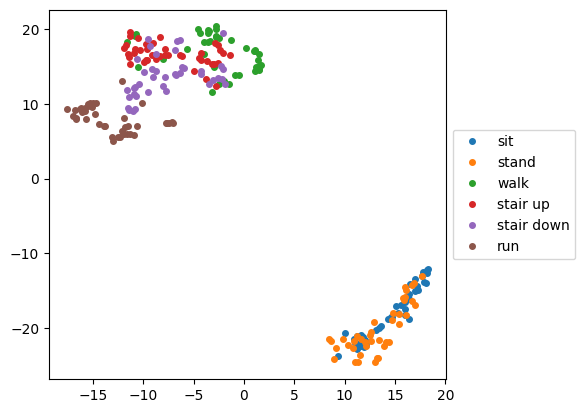

In [44]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=100)

In [45]:
model_lam = 100
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim3',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:827.9495, Loss-ae:823.2922, Loss-topo:0.0466
Epoch:2, P:None, Loss:814.0932, Loss-ae:813.9468, Loss-topo:0.0015
Epoch:3, P:None, Loss:820.8239, Loss-ae:820.7554, Loss-topo:0.0007
Epoch:4, P:None, Loss:815.7467, Loss-ae:815.6936, Loss-topo:0.0005
Epoch:5, P:None, Loss:812.6550, Loss-ae:812.6123, Loss-topo:0.0004
Epoch:6, P:None, Loss:816.5015, Loss-ae:816.4435, Loss-topo:0.0006
Epoch:7, P:None, Loss:806.9675, Loss-ae:806.9012, Loss-topo:0.0007
Epoch:8, P:None, Loss:815.2513, Loss-ae:815.1346, Loss-topo:0.0012
Epoch:9, P:None, Loss:807.8714, Loss-ae:807.8325, Loss-topo:0.0004
Epoch:10, P:None, Loss:816.9528, Loss-ae:816.9046, Loss-topo:0.0005
Epoch:11, P:None, Loss:816.8300, Loss-ae:816.7769, Loss-topo:0.0005
Epoch:12, P:None, Loss:811.5688, Loss-ae:811.4845, Loss-topo:0.0008
Epoch:13, P:None, Loss:819.0379, Loss-ae:818.9823, Loss-topo:0.0006
Epoch:14, P:None, Loss:815.4281, Loss-ae:815.3817, Loss-topo:0.0005
Epoch:15, P:None, Loss:812.6415, Loss-ae:812.5831, Loss-t

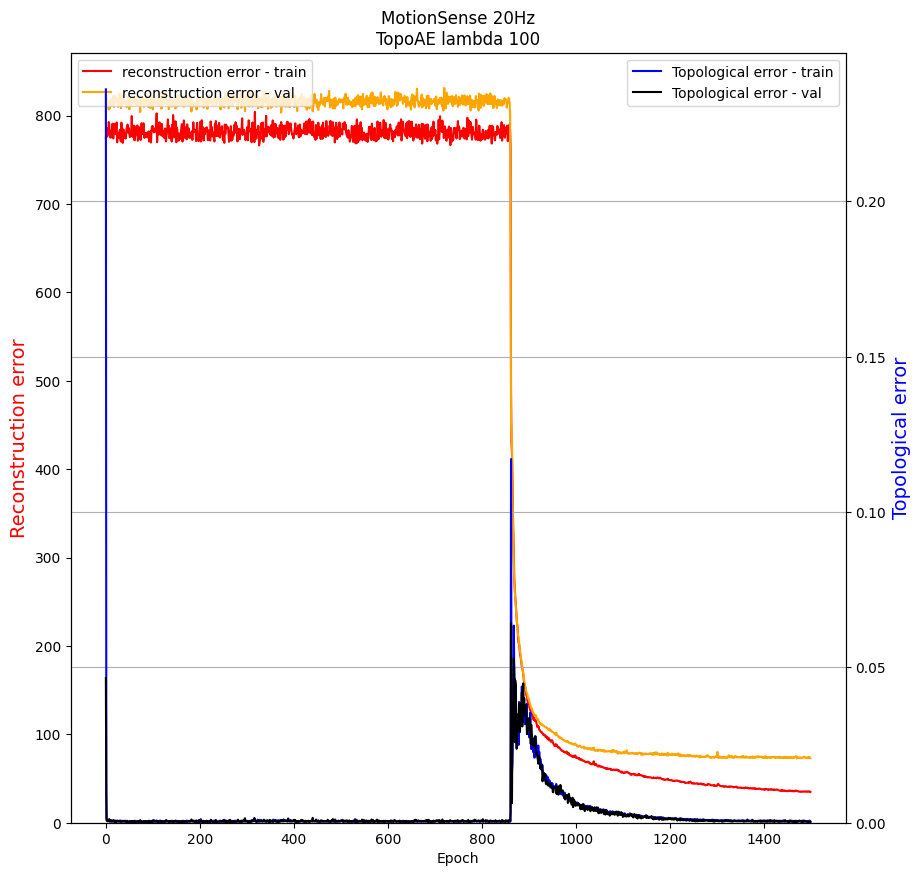

In [46]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [47]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [48]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [49]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7743902439024389,
 'RF-F1': 0.7731122102470047,
 'SVC-ACC': 0.7073170731707317,
 'SVC-F1': 0.7218190723585766,
 'KNN-ACC': 0.7439024390243902,
 'KNN-F1': 0.7450868872723815}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


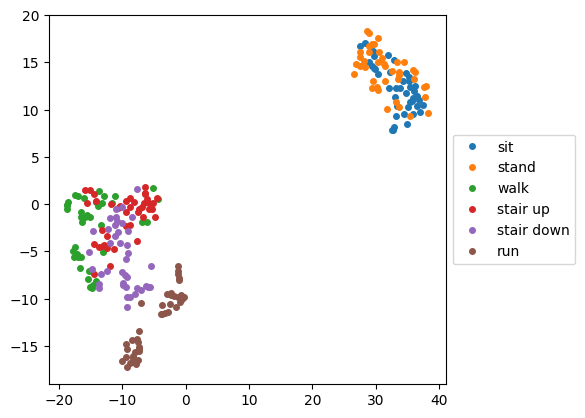

In [50]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=0.1)

In [51]:
model_lam = 0.1
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim3',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:466.6520, Loss-ae:455.6487, Loss-topo:110.0334
Epoch:2, P:None, Loss:388.9093, Loss-ae:379.4393, Loss-topo:94.7003
Epoch:3, P:None, Loss:359.2651, Loss-ae:351.9223, Loss-topo:73.4278
Epoch:4, P:None, Loss:334.9080, Loss-ae:324.1223, Loss-topo:107.8574
Epoch:5, P:None, Loss:290.8875, Loss-ae:275.1381, Loss-topo:157.4941
Epoch:6, P:None, Loss:270.5105, Loss-ae:258.0016, Loss-topo:125.0883
Epoch:7, P:None, Loss:250.1376, Loss-ae:239.2614, Loss-topo:108.7624
Epoch:8, P:None, Loss:238.1492, Loss-ae:225.3681, Loss-topo:127.8116
Epoch:9, P:None, Loss:223.0788, Loss-ae:210.8706, Loss-topo:122.0821
Epoch:10, P:None, Loss:206.0817, Loss-ae:194.7456, Loss-topo:113.3605
Epoch:11, P:None, Loss:195.3297, Loss-ae:182.8169, Loss-topo:125.1281
Epoch:12, P:None, Loss:185.1592, Loss-ae:173.2197, Loss-topo:119.3954
Epoch:13, P:None, Loss:179.1093, Loss-ae:168.3295, Loss-topo:107.7984
Epoch:14, P:None, Loss:169.4772, Loss-ae:159.4328, Loss-topo:100.4449
Epoch:15, P:None, Loss:161.4894

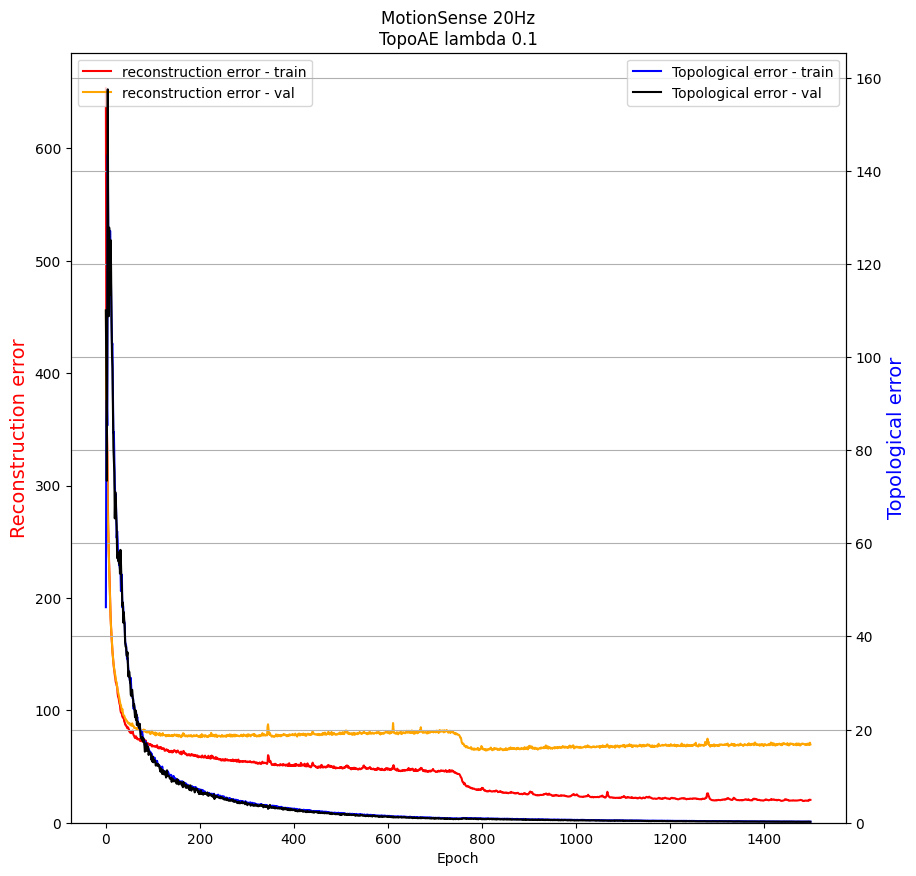

In [52]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [53]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [54]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [55]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.6764227642276424,
 'RF-F1': 0.7036089219924406,
 'SVC-ACC': 0.6829268292682927,
 'SVC-F1': 0.7370524889459421,
 'KNN-ACC': 0.6463414634146342,
 'KNN-F1': 0.6680978546079868}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


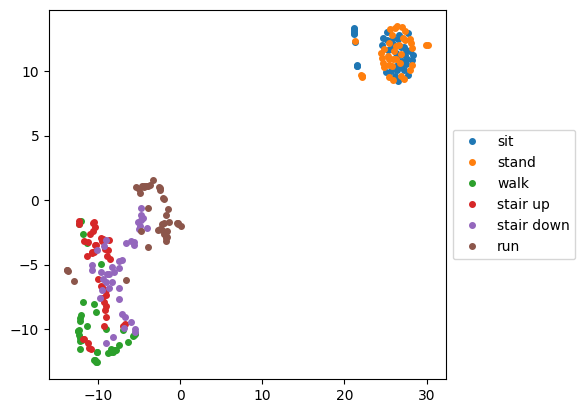

In [56]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=0.01)

In [57]:
model_lam = 0.01
topo_reducer = CustomTopoDimRedTransform(
    model_name='ConvolutionalAutoencoder_custom_dim3',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim3
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:464.1302, Loss-ae:461.5872, Loss-topo:254.3058
Epoch:2, P:None, Loss:391.9103, Loss-ae:389.6535, Loss-topo:225.6875
Epoch:3, P:None, Loss:360.6034, Loss-ae:357.0053, Loss-topo:359.8041
Epoch:4, P:None, Loss:330.0018, Loss-ae:325.1197, Loss-topo:488.2075
Epoch:5, P:None, Loss:279.7087, Loss-ae:269.1111, Loss-topo:1059.7587
Epoch:6, P:None, Loss:256.6634, Loss-ae:246.1348, Loss-topo:1052.8656
Epoch:7, P:None, Loss:233.4713, Loss-ae:224.7762, Loss-topo:869.5070
Epoch:8, P:None, Loss:221.6617, Loss-ae:211.4709, Loss-topo:1019.0779
Epoch:9, P:None, Loss:210.1540, Loss-ae:201.6499, Loss-topo:850.4077
Epoch:10, P:None, Loss:201.0693, Loss-ae:193.1228, Loss-topo:794.6504
Epoch:11, P:None, Loss:193.7782, Loss-ae:185.4895, Loss-topo:828.8664
Epoch:12, P:None, Loss:185.0216, Loss-ae:177.3853, Loss-topo:763.6357
Epoch:13, P:None, Loss:179.2083, Loss-ae:171.6294, Loss-topo:757.8922
Epoch:14, P:None, Loss:171.8674, Loss-ae:164.3824, Loss-topo:748.4963
Epoch:15, P:None, Loss:164

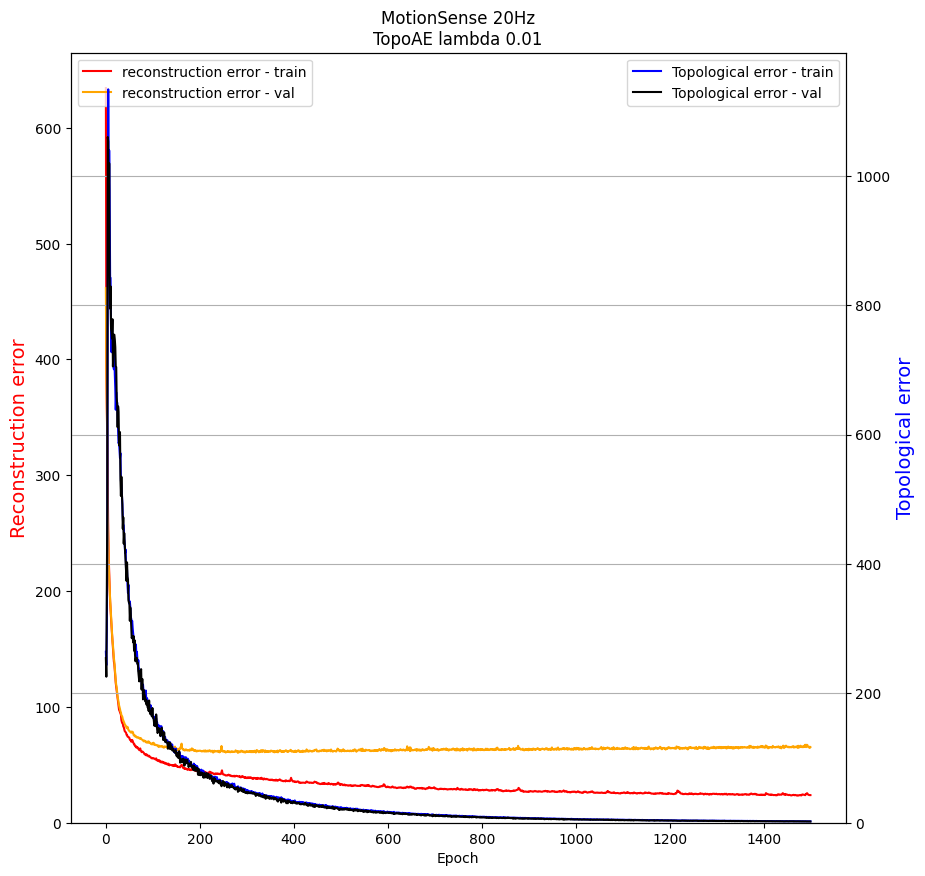

In [58]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [59]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [60]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [61]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7211382113821139,
 'RF-F1': 0.7185235617360449,
 'SVC-ACC': 0.7073170731707317,
 'SVC-F1': 0.762225443932761,
 'KNN-ACC': 0.7235772357723578,
 'KNN-F1': 0.7216745185519229}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


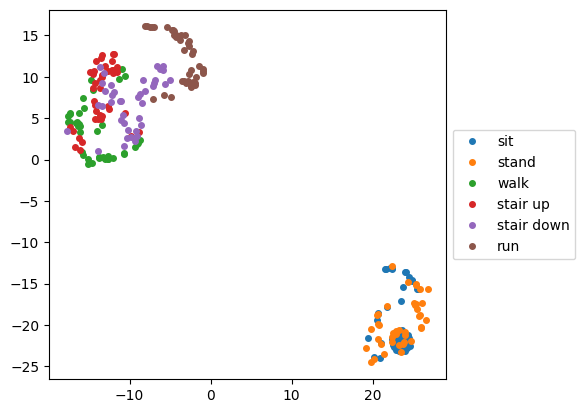

In [62]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)